In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import os
from rdb_functions import generate_b1_b0
from rdb_functions import fill_nas


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [110]:
data_bj=pd.read_csv(os.path.join('data','BJ_to_model.csv'))
data_gam=pd.read_csv(os.path.join('data','GAM_to_model.csv'))

# var_drop='tvivhab tvivpar vivpar_hab vivpar_ut tvivhab tvivpar vivpar_hab vivpar_ut pct_t_inhab_hh pct_privhh pct_privhh_inhab pct_hhtemp'.split()
# data.drop(columns=var_drop,inplace=True)

In [111]:
cl=[i not in list(data_bj) for i in list(data_gam)]
list(compress(list(data_gam),cl))

['Price_m2']

In [112]:
print(data_bj.shape)
print(data_gam.shape)

(311, 32)
(345, 32)


In [113]:
data_gam.rename(columns={'Price_m2':'price_m2'},inplace=True)

In [114]:
# data_bj['bj']=1
# data_gam['bj']=0
# data=data_gam.append(data_bj,ignore_index=True)
data=data_bj

In [115]:
data_20=data[data['tiempo']==2020].reset_index(drop=True)
data_10=data[data['tiempo']==2010].reset_index(drop=True)

print(data_20.shape)
print(data_10.shape)

(154, 32)
(154, 32)


In [116]:
data_10.head()

,id,price_m2,tiempo,pobtot,p_0a2,p_60ymas,prom_hnv,graproes,graproes_f,pocupada,pocupada_f,pder_ss,vivtot,tvivhab,tvivpar,vivpar_hab,vivpar_ut,prom_ocup,vph_2ymasd,vph_autom,vph_pc,vph_inter,pct_0a2,pct_60,pct_wf,pct_t_inhab_hh,pct_privhh,pct_privhh_inhab,pct_hhtemp,pct_hh_car,pct_hh_pc,pct_hh_int
0,01400010011010,38700.178151,2010.0,606.0,22.0,59.0,0.99,14.49,14.11,327.0,154.0,440.0,289.0,NaN,NaN,NaN,NaN,2.50,156.0,163.0,182.0,163.0,3.630363,9.735974,47.094801,NaN,NaN,NaN,NaN,56.401384,62.975779,56.401384
1,01400010011013,28922.651934,2010.0,298.0,7.0,43.0,1.16,13.56,13.09,159.0,73.0,219.0,149.0,NaN,NaN,NaN,NaN,2.38,66.0,74.0,85.0,78.0,2.348993,14.429530,45.911950,NaN,NaN,NaN,NaN,49.664430,57.046980,52.348993
2,01400010011014,37155.963303,2010.0,263.0,16.0,25.0,1.31,13.62,13.04,125.0,57.0,183.0,125.0,NaN,NaN,NaN,NaN,2.69,55.0,54.0,65.0,59.0,6.083650,9.505703,45.600000,NaN,NaN,NaN,NaN,43.200000,52.000000,47.200000
3,01400010026013,28277.634961,2010.0,412.0,13.0,38.0,1.11,13.95,13.57,220.0,108.0,267.0,184.0,NaN,NaN,NaN,NaN,2.50,79.0,77.0,115.0,101.0,3.155340,9.223301,49.090909,NaN,NaN,NaN,NaN,41.847826,62.500000,54.891304
4,01400010030008,28092.783505,2010.0,262.0,4.0,52.0,1.60,11.96,11.39,127.0,63.0,199.0,94.0,NaN,NaN,NaN,NaN,3.01,52.0,40.0,48.0,44.0,1.526718,19.847328,49.606299,NaN,NaN,NaN,NaN,42.553191,51.063830,46.808511


29


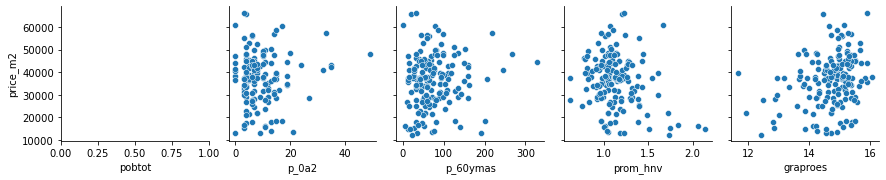

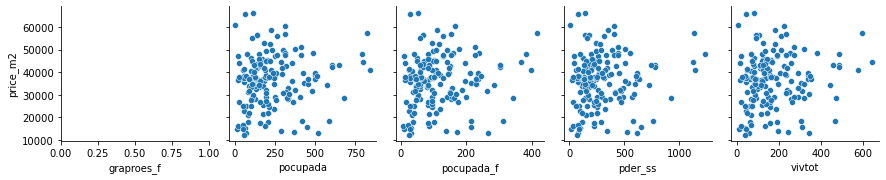

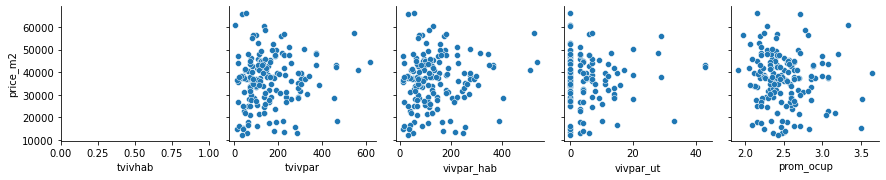

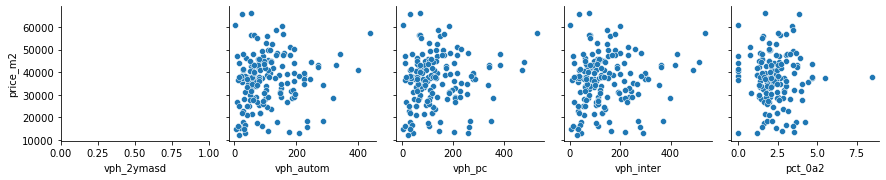

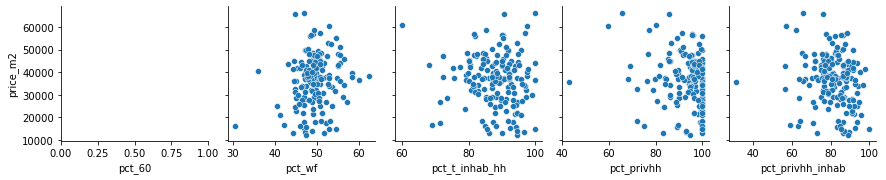

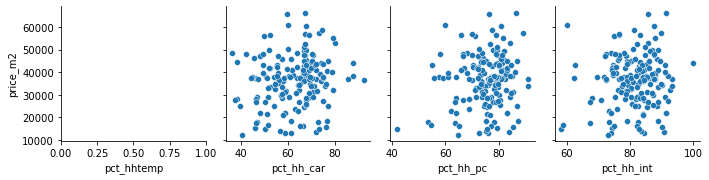

In [82]:
variables_plot=list(data_10.drop(columns=['id','price_m2','tiempo','lat','long']))

total=len(variables_plot)
print(total)
i=0
while i<total:
    
    try:
        pp = sns.pairplot(data=data_20,
                      y_vars=['price_m2'],
                      x_vars=variables_plot[i:i+5])
        i=i+5
    except:
        pp = sns.pairplot(data=data_20,
                      y_vars=['price_m2'],
                      x_vars=variables_plot[i:])
    
    

In [117]:
X=data_20.drop(columns=['price_m2','id','tiempo'])
y=data_20.price_m2

In [118]:
nas=X.isna().sum()

In [119]:
nas

pobtot               0
p_0a2               21
p_60ymas             0
prom_hnv             0
graproes             0
graproes_f           0
pocupada             0
pocupada_f           1
pder_ss              0
vivtot               0
tvivhab              0
tvivpar              0
vivpar_hab           1
vivpar_ut           44
prom_ocup            0
vph_2ymasd           1
vph_autom            0
vph_pc               0
vph_inter            0
pct_0a2             21
pct_60               0
pct_wf               1
pct_t_inhab_hh       0
pct_privhh           0
pct_privhh_inhab     1
pct_hhtemp          44
pct_hh_car           0
pct_hh_pc            0
pct_hh_int           0
dtype: int64

## Filling NAs with linear regression

In [120]:
variables_kept=['pct_hh_pc','pct_wf','pobtot','pct_hh_car','graproes']

X_filled=X[variables_kept].copy()

for column in list(X_filled):
    b1_b0=generate_b1_b0(X,'pobtot',column)
    X_filled[column]=fill_nas(X_filled[column],X_filled['pobtot'],b1_b0)

In [121]:
print(X_filled.isna().sum())
print(X_filled.shape)

pct_hh_pc     0
pct_wf        0
pobtot        0
pct_hh_car    0
graproes      0
dtype: int64
(154, 5)


## Standarizing features

In [122]:
X_filled.drop(columns=['pobtot'],inplace=True)
scaler = preprocessing.StandardScaler().fit(X_filled)
X_scaled = scaler.transform(X_filled)

## Splitting in train and test

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size=0.33, random_state=42)

In [124]:
corlist=['price_m2']
corlist.extend(variables_kept)

<AxesSubplot:>

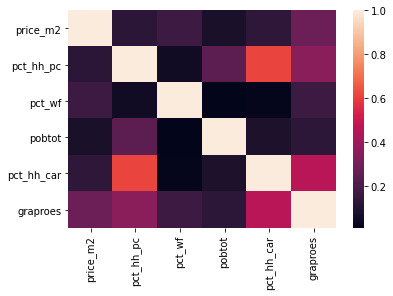

In [125]:
sns.heatmap((data_20[corlist]).corr())

### Gradient Boosting Regressor

In [126]:
gbr = GradientBoostingRegressor(
learning_rate=0.1,
n_estimators=200,
subsample=0.6,
random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=42, subsample=0.6)

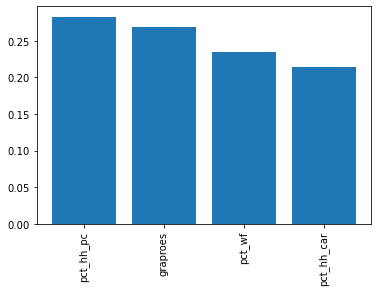

In [127]:
# feature importances from random forest model
importances = gbr.feature_importances_
# index of greatest to least feature importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
# create tick labels
feature_names=list(X_filled)
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
# rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [97]:
variables_kept

['pct_hh_pc', 'pct_wf', 'pobtot', 'pct_hh_car', 'graproes']

In [128]:
X_10=data_10.drop(columns=['price_m2','id','tiempo'])

X_filled_10=X_10[variables_kept].copy()

for column in list(X_filled_10):
    b1_b0=generate_b1_b0(X_filled_10,'pobtot',column)
    X_filled_10[column]=fill_nas(X_filled_10[column],X_filled_10['pobtot'],b1_b0)

X_filled_10.drop(columns=['pobtot'],inplace=True)
    
gbr.predict(X_filled_10)
    
growth=100*(y/gbr.predict(X_filled_10))-100
    
predictions=pd.DataFrame({'precio m2 2010 predicted':gbr.predict(X_filled_10),
               'precio m2 2020':y,
               'growth':growth})

In [129]:
print(data_10.shape)
print(X_filled_10.shape)

(154, 32)
(154, 4)


In [131]:
data_10['growth']=growth
results=data_10[['id','growth']]

In [132]:
predictions.describe()

,precio m2 2010 predicted,precio m2 2020,growth
count,154.000000,154.000000,154.000000
mean,32447.378555,36297.835132,20.564723
std,8534.392421,11477.179341,56.545571
min,11801.755412,12222.222222,-64.689326
25%,25756.974746,28556.212434,-14.973478
50%,33241.913781,37414.232809,8.907796
75%,38472.860428,43125.739166,39.159309
max,49969.902074,66483.516484,261.096563


In [133]:
predictions.sort_values('precio m2 2020')

,precio m2 2010 predicted,precio m2 2020,growth
119,23979.664265,12222.222222,-49.030887
113,30394.265351,13044.927536,-57.080958
93,29713.744357,13227.272727,-55.484329
37,15188.756036,13379.850000,-11.909507
131,18967.214199,13944.281525,-26.482185
102,42293.756268,14934.210526,-64.689326
151,31344.124730,15000.000000,-52.144141
20,18881.902427,15109.890110,-19.976866
125,40419.184560,15600.000000,-61.404466
99,18597.799446,16121.495327,-13.315038


95
154


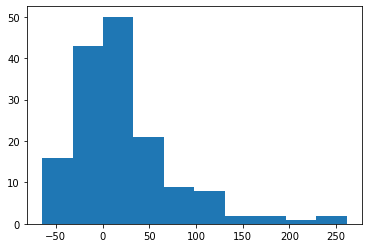

In [134]:
Q1 = growth.quantile(0.25)
Q3 = growth.quantile(0.75)
IQR = Q3 - Q1

cl=(growth < (Q1 - 1.5 * IQR)) |(growth > (Q3 + 1.5 * IQR))
# results=results[~cl]

plt.hist(results['growth'])
print((results['growth']>0).sum())
print(len(results['growth']))

In [135]:
results.to_csv(os.path.join('data','results.csv'),index=False)

Percentage change in pct_hh_pc


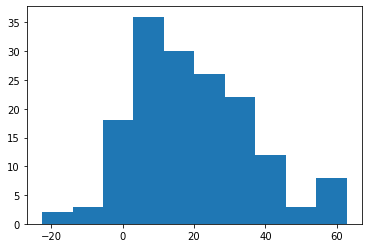

Percentage change in pct_wf


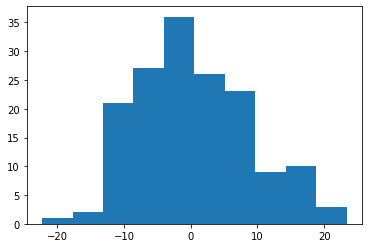

Percentage change in pct_hh_car


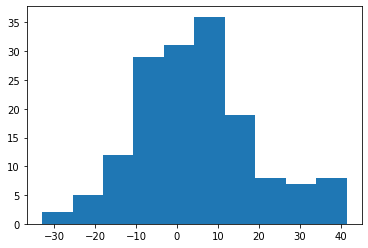

Percentage change in graproes


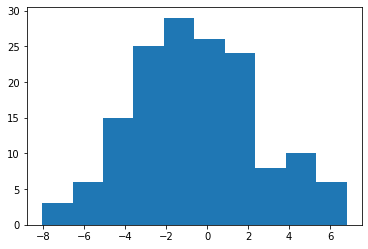

In [105]:
for column in list(X_filled):
    change=100*(X_filled[column]/(1+X_filled_10[column]))-100
    Q1 = change.quantile(0.25)
    Q3 = change.quantile(0.75)
    IQR = Q3 - Q1

    cl=(change < (Q1 - 1.5 * IQR)) |(change > (Q3 + 1.5 * IQR))
    change=change[~cl]

    print(f'Percentage change in {column}')
    plt.hist(change)
    plt.show()
    

In [106]:
import statsmodels.api as sm
model = LinearRegression()
    
model.fit(X_filled, y)
model = LinearRegression().fit(X_filled, y)


pd.DataFrame({'names':list(X_filled),
              'coeff':model.coef_})


est = sm.OLS(y, X_filled)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:               price_m2   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              464.0
Date:                Wed, 17 Feb 2021   Prob (F-statistic):                    2.91e-88
Time:                        17:11:32   Log-Likelihood:                         -1800.0
No. Observations:                 168   AIC:                                      3608.
Df Residuals:                     164   BIC:                                      3621.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------